In [1]:
import sys
sys.path.append("/home/alexander/Work/Repos/")
from batchflow.models.tf import DeepGalerkin
from batchflow import Pipeline, Dataset, DatasetIndex, Batch, B, L, F, V
from batchflow import NumpySampler as NS
import numpy as np
import matplotlib.pyplot as plt
import batchflow
from tqdm import tqdm_notebook

In [2]:
import tensorflow as tf

### Configuring `DeepGalerkin` model for solving ODE
$$\frac{d f}{d t}= 2\pi\cos[2 \pi t],\quad f(0)=1.$$

* Training points are from uniform distribution on **[0, 1]**, as the equation is solved on that domain.

In [6]:
s = NS('u') # 'u' stands for u_niform distribution

* setting up `config` for `DeepGalerkin`-model

In [7]:
layout = 'fafaf'
initial_condition = 1
form_lhs = {'d1': (1, )}
Q_rhs = lambda t: 2 * np.pi * tf.cos(2 * np.pi * t)

config = {
    'inputs': dict(points={'shape': (1, )}),
    'initial_block/inputs': 'points',
    'body': dict(layout=layout,
                 units=[10, 15, 1],
                 activation=[tf.nn.tanh, tf.nn.tanh]),
    'common': dict(form=form_lhs,
                   bind_bc_ic=True,
                   initial_condition=initial_condition,
                   Q=Q_rhs,
                   time_multiplier='sigmoid'),
    'loss': 'mse'}

Note:
* `f` in `layout=[fafaf]` stands for a **f**ully-connected layer
* `a` in `layout=[fafaf]` stands for **a**ctivation-function

So, coupled with `activation=[tf.nn.tanh, tf.nn.tanh]` and `units=[10, 15, 1]`, `layout='fafaf'` sets up a fully-connected network with 2 hidden layers (with 10 and 15 units) and `tanh`-activations.

Note also:
* `form={'d1':(1, )}` sets up the left-hand-side of the equation as $$\frac{d f}{d t}=\dots$$
`form={'d1':(1, ), 'd2':(2, )}` would set it to be $$\frac{d f}{d t} + 2\frac{d^2 f}{d t^2}=\dots$$
* `Q_rhs = lambda t: 2 * np.pi * tf.cos(2 * np.pi * t)` says that the right-hand side of the equation is given by
$$\dots = 2\pi\cos[2 \pi t]$$
* `initial_condition=1` states that initial condition is given by
$$ f(0) = 1 $$

### Preparing training `pipeline` 

In [8]:
pipeline = (Pipeline()
            .init_variable('loss', default=[])
            .init_variable('dt', default=[])
            .init_model('static', DeepGalerkin, 'DG', config)
            .train_model('DG',
                         feed_dict={'points': L(s.sample, size=F(len))},
                         fetches='loss',
                         save_to=V('loss'), mode='a'))

In [9]:
dsix = DatasetIndex(np.arange(100))
pipeline_ds = Dataset(dsix) >> pipeline

### Running 3000-iters of network-training

In [10]:
dg = pipeline_ds.get_model_by_name('DG')

In [11]:
for i in tqdm_notebook(range(3000)):
    pipeline_ds.next_batch(20, n_epochs=None)

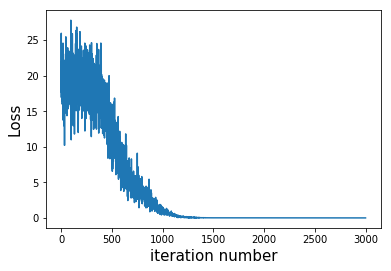

In [12]:
plt.plot(pipeline_ds.get_variable('loss')[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
pass

### Plot the network solution vs (a bit shifted) true solution

* The solution to the equation under consideration is given by
$$
f(t) = \sin[2\pi t] + 1
$$
When plotting, we shift it a bit, in order for it to be distinguishable from network-approximation.

In [13]:
sol = lambda t: np.sin(2 * np.pi * t) + 1

In [14]:
pts = np.linspace(0, 1, 200).reshape(-1, 1)
approxs = dg.session.run(dg.approximator, feed_dict={dg.points: pts})
true = [sol(t[0]) + 0.1 for t in pts]

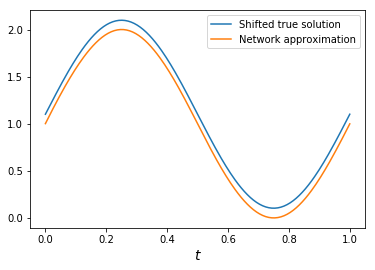

In [15]:
plt.plot(pts, true, label='Shifted true solution')
plt.plot(pts, approxs, label='Network approximation')
plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()